In [23]:
from tensordict import TensorDict
import matplotlib.pyplot as plt
from world_machine_experiments.toy1d.base.train import MSELossOnlyFirst
import numpy as np

In [24]:
complete_ps = TensorDict.load("D:\\Github\\WorldMachine\\experiments\\toy1d_experiment0_protocol_test\\CompleteProtocol\\run_0\\metrics_logits\\prediction_shallow")
complete_target = TensorDict.load("D:\\Github\\WorldMachine\\experiments\\toy1d_experiment0_protocol_test\\CompleteProtocol\\run_0\\metrics_logits\\targets")

sensorialm_ps = TensorDict.load("D:\\Github\\WorldMachine\\experiments\\toy1d_experiment0_protocol_test\\SensorialMask\\run_0\\metrics_logits\\prediction_shallow")
sensorialm_target = TensorDict.load("D:\\Github\\WorldMachine\\experiments\\toy1d_experiment0_protocol_test\\SensorialMask\\run_0\\metrics_logits\\targets")

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Github\\WorldMachine\\experiments\\toy1d_experiment0_protocol_test\\CompleteProtocol\\run_0\\metrics_logits\\prediction_shallow\\meta.json'

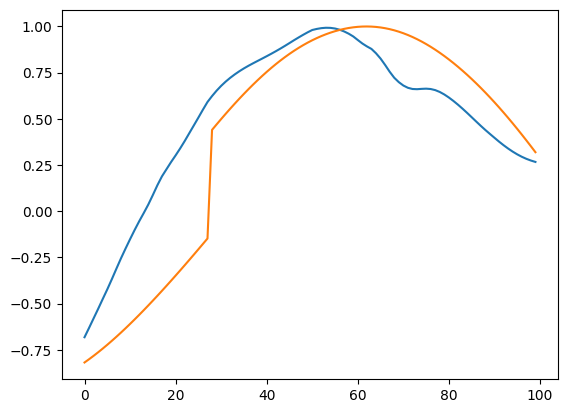

In [ ]:
plt.plot(complete_ps["state_decoded"][1,:,0])
plt.plot(complete_target["state_decoded"][1,100:,0])

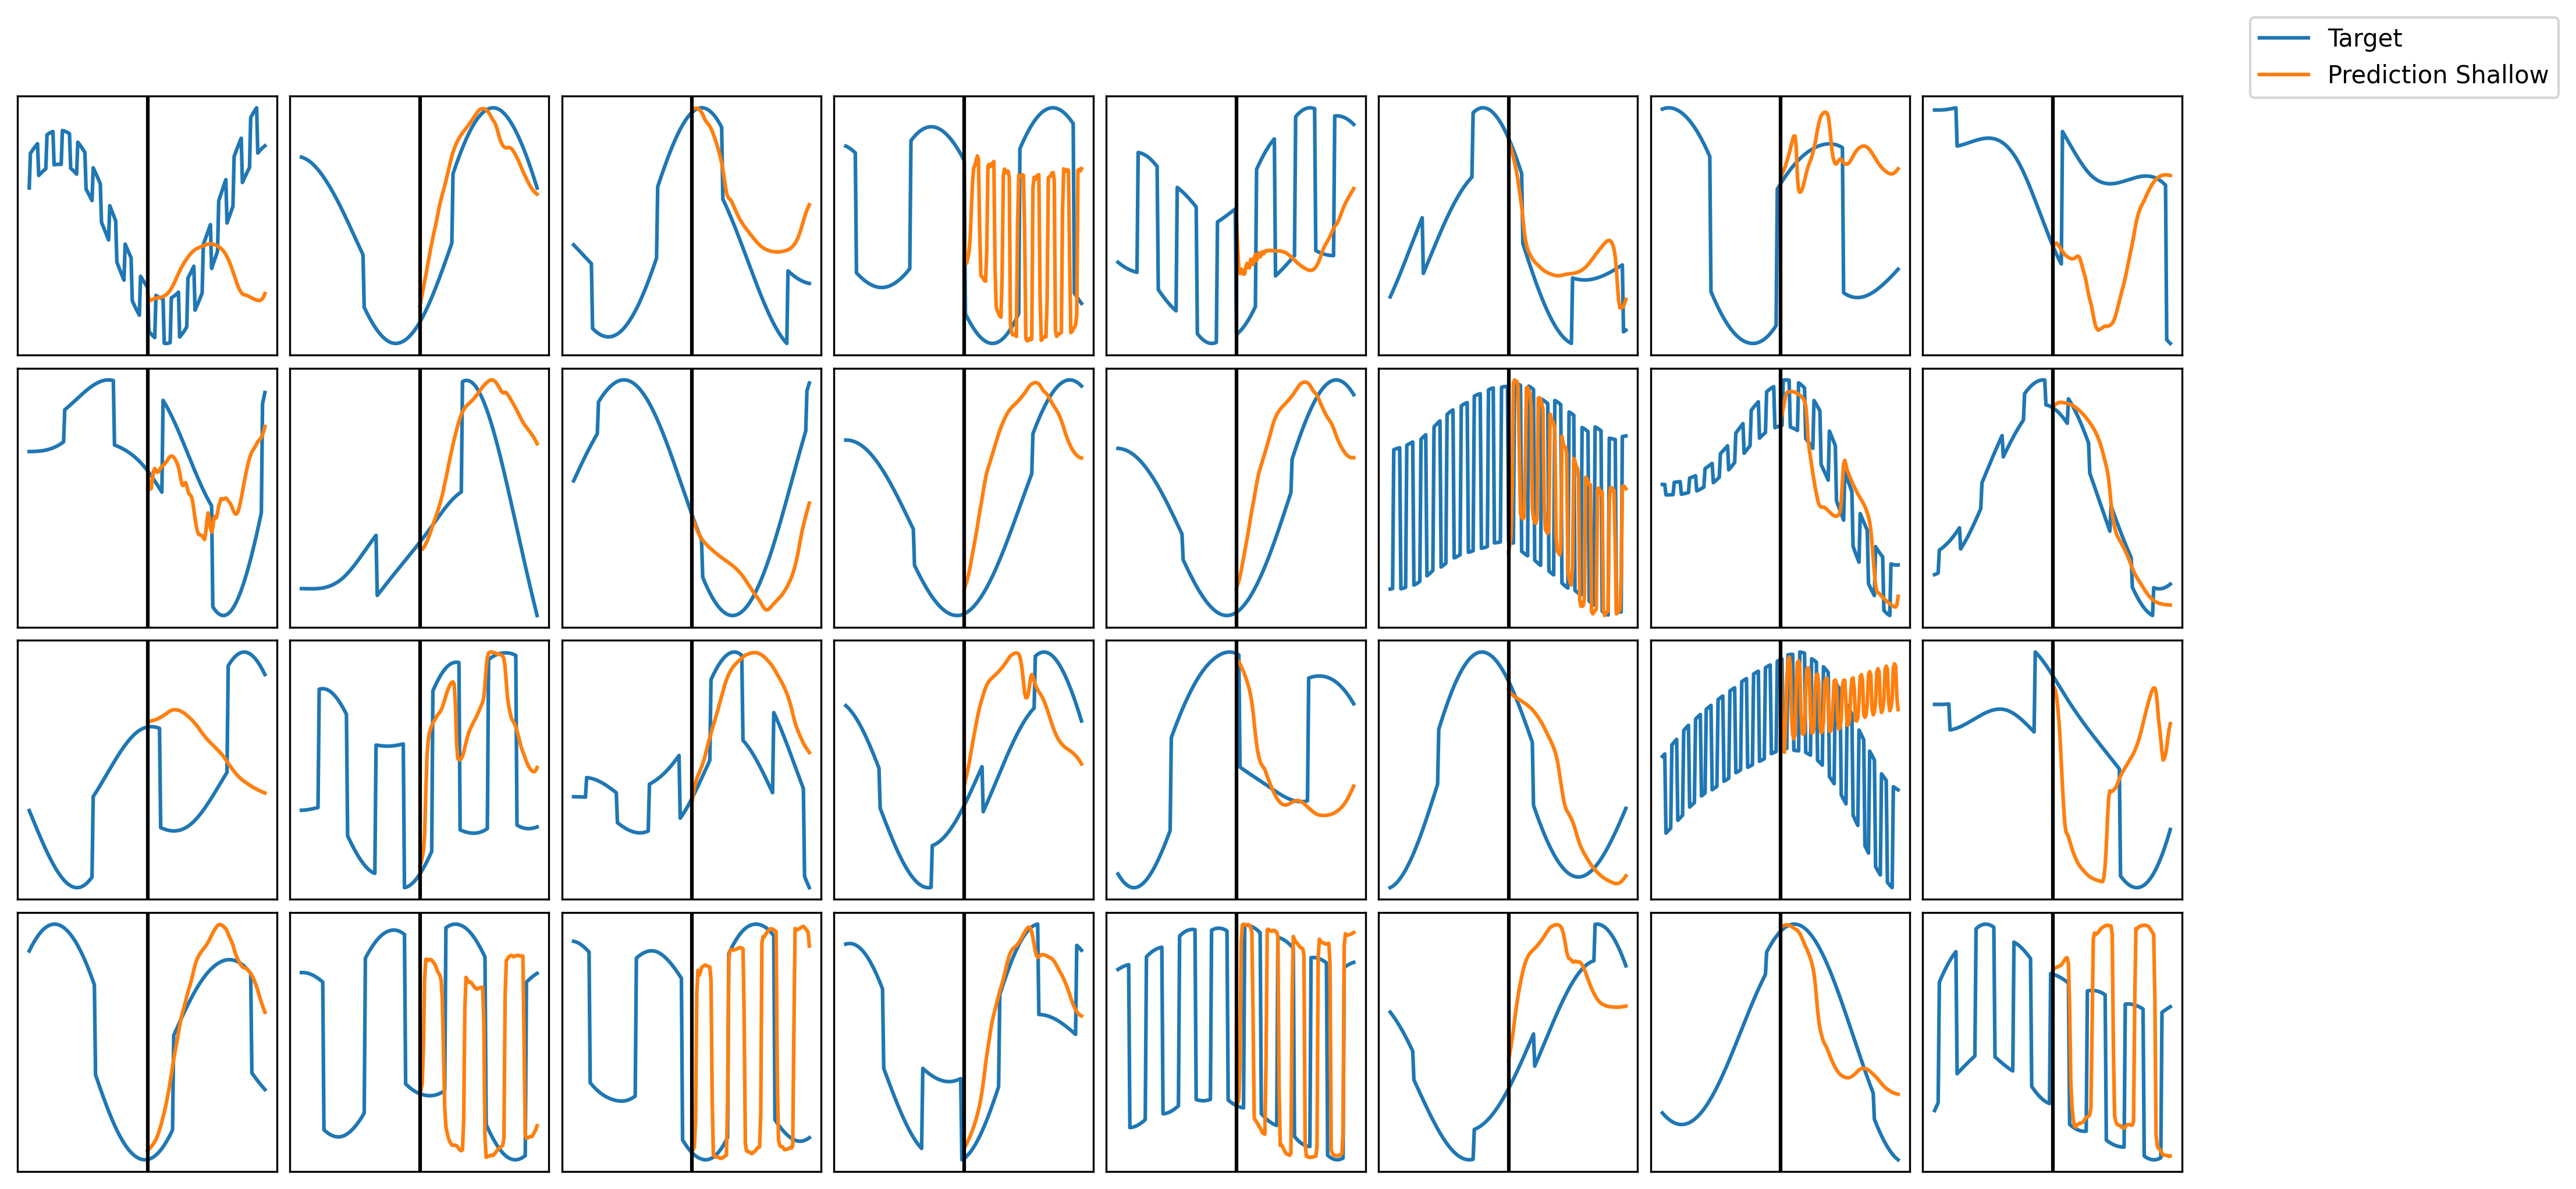

In [ ]:
time = np.linspace(0, 199, 200, dtype=int)




axis = 0
fig, axs = plt.subplots(4, 8, dpi=300, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)

for i in range(32):
    row = i // 8
    column = i % 8

    axs[row, column].plot(complete_target["state_decoded"][i,:,0], label="Target")

    axs[row, column].plot(time[100:], complete_ps["state_decoded"][i,:,0], label="Prediction Shallow")


    axs[row, column].set_xticks([])
    axs[row, column].set_yticks([])
    #axs[row, column].set_ylim(-1,1)

    axs[row, column].axvline(100, color="black")

plt.legend(bbox_to_anchor=(2.5, 4.5), loc='upper right')


plt.show()


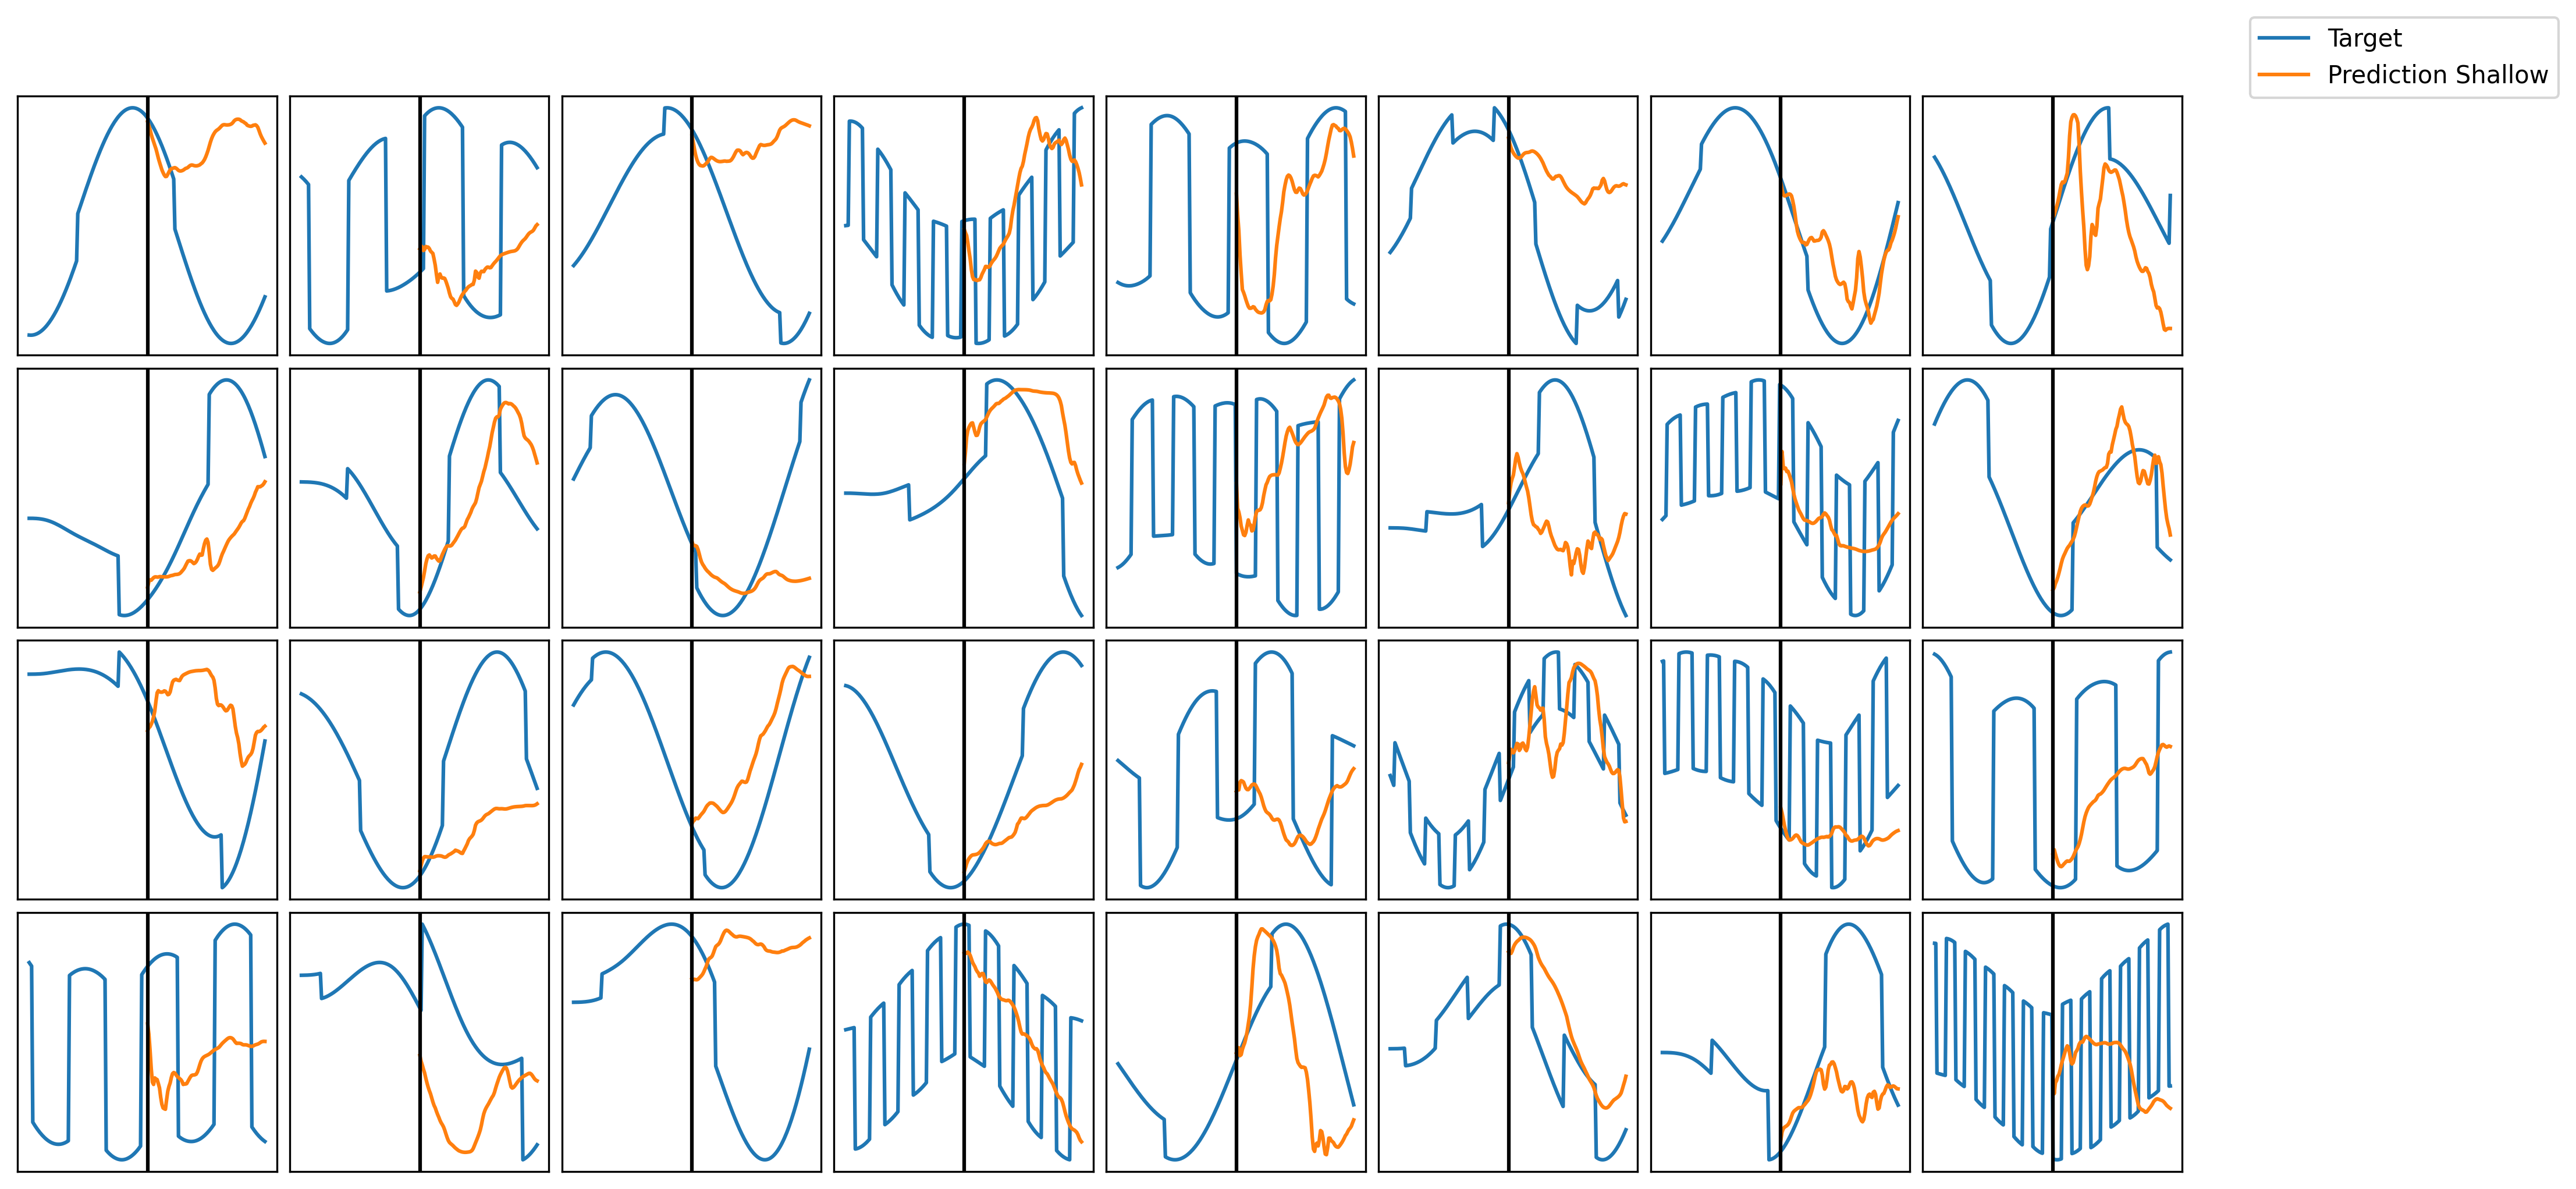

In [ ]:
time = np.linspace(0, 199, 200, dtype=int)




axis = 0
fig, axs = plt.subplots(4, 8, dpi=300, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)

for i in range(32):
    row = i // 8
    column = i % 8

    axs[row, column].plot(sensorialm_target["state_decoded"][i,:,0], label="Target")

    axs[row, column].plot(time[100:], sensorialm_ps["state_decoded"][i,:,0], label="Prediction Shallow")


    axs[row, column].set_xticks([])
    axs[row, column].set_yticks([])
    #axs[row, column].set_ylim(-1,1)

    axs[row, column].axvline(100, color="black")

plt.legend(bbox_to_anchor=(2.5, 4.5), loc='upper right')


plt.show()


In [ ]:
mse = MSELossOnlyFirst()

In [ ]:
mse(complete_ps["state_decoded"], complete_target["state_decoded"][:,100:])

tensor(0.5361)

In [ ]:
mse(sensorialm_ps["state_decoded"], sensorialm_target["state_decoded"][:,100:])

tensor(0.6980)

In [25]:
import pysdtw

In [26]:
sdtw = pysdtw.SoftDTW(gamma=.1, use_cuda=True)

In [ ]:
complete_ps = complete_ps.cuda()
complete_target = complete_target.cuda()

sensorialm_ps = sensorialm_ps.cuda()
sensorialm_target = sensorialm_target.cuda()

In [ ]:
sdtw(complete_ps["state_decoded"][:,:,0].unsqueeze(-1), complete_target["state_decoded"][:, 100:,0].unsqueeze(-1)).mean()

tensor(11.2516, device='cuda:0')

In [ ]:
sdtw(sensorialm_ps["state_decoded"][:,:,0].unsqueeze(-1), sensorialm_target["state_decoded"][:, 100:,0].unsqueeze(-1)).mean()

tensor(35.7510, device='cuda:0')

In [ ]:
raise ValueError

In [ ]:

import numpy as np

from hamilton import driver
import torch
from world_machine_experiments import  shared
from world_machine_experiments.toy1d import base



In [ ]:
generator = np.random.default_rng(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'



inputs = {"sequence_length": 1000,
            "n_sequence": 10000,
            "context_size": 200,
            "state_dimensions": None,
            "batch_size": 32,
            "device": device,
            "seed":[0, 42],
            "state_control": "periodic",
            "measurement_shift": 0,
            "state_dimensions":[0]
        }

d = driver.Builder().with_modules(base, shared).build()

In [ ]:
outputs = d.execute(["toy1d_data", "toy1d_dataloaders"], inputs=inputs)

In [ ]:
item = next(iter(outputs["toy1d_dataloaders"]["train"]))

In [ ]:
item["inputs"]

TensorDict(
    fields={
        measurement: Tensor(shape=torch.Size([32, 200, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        state_control: Tensor(shape=torch.Size([32, 200, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        state_decoded: Tensor(shape=torch.Size([32, 200, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([32, 200]),
    device=None,
    is_shared=False)

In [ ]:
from world_machine.train.stages import SensorialMasker

In [ ]:
sm = SensorialMasker(0.1, True)

In [ ]:
sm.pre_segment([item], {}, 32, 200, 0, "cpu", 128, 0)

In [ ]:
from world_machine_experiments.toy1d.base.train import toy1d_criterion_set
from world_machine_experiments.toy1d.base.mask_sensorial import toy1d_mask_sensorial_metrics

In [ ]:
model = torch.load("D:\\Github\\WorldMachine\\experiments\\toy1d_experiment0_protocol_test\\CompleteProtocol\\run_0\\toy1d_model.pt", weights_only=False)

In [ ]:
dataset = outputs["toy1d_dataloaders"]["val"].dataset

In [ ]:
from torch.utils.data import random_split
dataset, _ = random_split(dataset, [32, len(dataset)-32])

In [ ]:
from world_machine.data import WorldMachineDataLoader

loaders = {"val": WorldMachineDataLoader(dataset, batch_size=32, shuffle=True,
                                                   drop_last=True,
                                                   num_workers=0,)}

In [ ]:
metrics = toy1d_mask_sensorial_metrics(model, loaders, toy1d_criterion_set())

Metrics Generation: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


torch.Size([32, 200, 3]) torch.Size([32, 200, 3]) torch.float32 torch.float32
torch.Size([32, 200, 2]) torch.Size([32, 200, 2]) torch.float32 torch.float32


Metrics Generation: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


torch.Size([32, 200, 3]) torch.Size([32, 200, 3]) torch.float32 torch.float32
torch.Size([32, 200, 2]) torch.Size([32, 200, 2]) torch.float32 torch.float32


Metrics Generation: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


torch.Size([32, 200, 3]) torch.Size([32, 200, 3]) torch.float32 torch.float32
torch.Size([32, 200, 2]) torch.Size([32, 200, 2]) torch.float32 torch.float32


Metrics Generation: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


torch.Size([32, 200, 3]) torch.Size([32, 200, 3]) torch.float32 torch.float32
torch.Size([32, 200, 2]) torch.Size([32, 200, 2]) torch.float32 torch.float32


Metrics Generation: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

torch.Size([32, 200, 3]) torch.Size([32, 200, 3]) torch.float32 torch.float32
torch.Size([32, 200, 2]) torch.Size([32, 200, 2]) torch.float32 torch.float32


In [ ]:
metrics

{'mask_sensorial_percentage': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 'state_decoded_mse': array([0.12987515, 0.13116145, 0.13464887, 0.17583188, 0.38421485]),
 'state_control_mse': array([0.18829334, 0.19091679, 0.1906586 , 0.18724552, 0.17970398]),
 'measurement_mse': array([0.15673509, 0.15732737, 0.1612855 , 0.20136894, 0.41359636]),
 'optimizer_loss': array([0.12987515, 0.13116145, 0.13464887, 0.17583188, 0.38421485])}

In [ ]:
import matplotlib.pyplot as plt

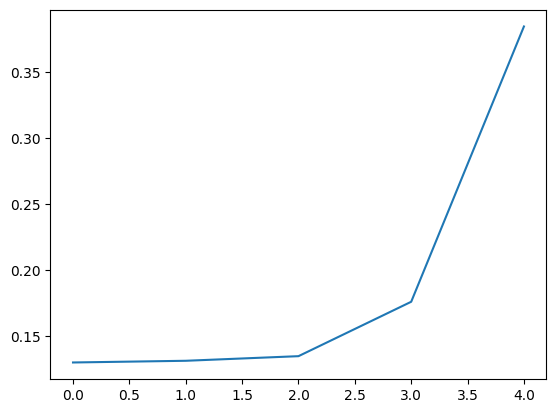

In [ ]:
plt.plot(metrics["state_decoded_mse"])

In [3]:
from pysdtw import SoftDTW
import torch
# Create the sequences
batch_size, len_x, len_y, dims = 8, 15, 12, 5
x = torch.rand((batch_size, len_x, dims), requires_grad=True)
y = torch.rand((batch_size, len_y, dims))
# Transfer tensors to the GPU
#x = x.cuda()
#y = y.cuda()
#
# Create the "criterion" object
sdtw = SoftDTW(use_cuda=False, gamma=0.1)

loss = sdtw(x, y)  # Just like any torch.nn.xyzLoss()


In [ ]:
from cuda.bindings import nvjitlink

In [ ]:
nvjitlink.check_status()

AttributeError: module 'cuda.bindings.nvjitlink' has no attribute 'check_status'